In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from fft_unwrap import unwrap_phase_fft
import matplotlib.pyplot as plt

In [2]:
%%time
# load in our wrapped phase data
fn_1 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180103T010924Z_20240428T014600Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180115T010923Z_20240428T051456Z_S1B_VV_v1.1.h5"

dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase')
ds.rio.write_crs('EPSG:32612', inplace=True)

CPU times: user 6.92 s, sys: 1.26 s, total: 8.18 s
Wall time: 8.44 s


<xarray.Dataset> Size: 409MB
Dimensions:      (x: 20670, y: 4941)
Coordinates:
  * x            (x) float64 165kB 7.14e+05 7.14e+05 ... 8.173e+05 8.173e+05
  * y            (y) float64 40kB 4.218e+06 4.218e+06 ... 4.169e+06 4.169e+06
    spatial_ref  int64 8B 0
Data variables:
    phase        (y, x) float32 409MB nan nan nan nan nan ... nan nan nan nan

In [3]:
%%time
# option to coarsen, but we won't
nx = 1
ny = 1
wrapped_phase_da = ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean()
wrapped_phase_np = wrapped_phase_da.values
# Unwrap the phase using our custom FFT-based function
unwrapped_np = unwrap_phase_fft(wrapped_phase_np)
# Convert back to an xarray DataArray with matching coordinates
unwrapped_da = xr.DataArray(unwrapped_np, dims=wrapped_phase_da.dims, coords=wrapped_phase_da.coords)
ds_unwrapped = unwrapped_da.to_dataset(name='unwrapped_phase')

CPU times: user 37.1 s, sys: 10.8 s, total: 47.9 s
Wall time: 48.5 s


In [6]:
# mask out based on original array since we fill in the masked values in our unwrap func
unwrapped_da = unwrapped_da.where(~np.isnan(ds.phase))

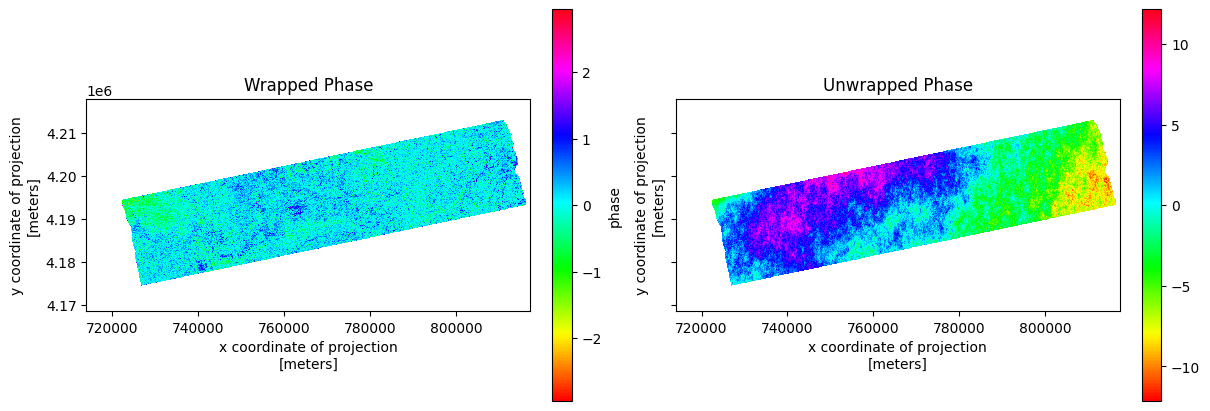

In [8]:
nx = 16
ny = 8
f, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharex=True, sharey=True)

ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0])
axs[0].set_title('Wrapped Phase')

unwrapped_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1])
axs[1].set_title('Unwrapped Phase')

for ax in axs:
    ax.set_aspect('equal')

plt.show()